실행 결과는 Examples - Train 섹션의 첫번째 CIFAR-10 Test 서브섹션에 있습니다.


---


다시 실행하시려면 Setup 섹션 전체를 한번 실행하신 후에 서브섹션을 실행하시면 됩니다.



중간에 Models 섹션을 실행하실 경우 모델이 초기화되거나 오류가 발생할 수 있습니다.

만약 Weight가 Freeze 되었는지 체크하시는 부분에서 오류가 발생하신다면 해당 부분의 주석처리 된 부분의 구문을 사용해주시면 됩니다.

GitHub의 tmp 폴더에는 이전 테스트용 버젼들을 업로드 해 놓았습니다.

# Setup
---

## Packages

In [ ]:
from functools import partial
from collections import OrderedDict

%config InlineBackend.figure_format = 'retina'

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision as tv

In [ ]:
import requests
import io

## Device


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Download Pretrained Weights for BiT

In [ ]:
def get_weights(bit_variant):
  response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
  response.raise_for_status()
  return np.load(io.BytesIO(response.content))

In [ ]:
weights = get_weights('BiT-M-R50x1')

In [ ]:
weights_cifar10 = get_weights('BiT-M-R50x1-CIFAR10')

In [ ]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

## Networks and Layers

###StdConv

In [ ]:
class StdConv2d(nn.Conv2d):

  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding,
                    self.dilation, self.groups)

In [ ]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)


###Conv Units

In [ ]:
class PreActConv(nn.Module):

  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.pretrained = False

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original code has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)


  def forward(self, x):
    out = self.relu(self.gn1(x))

    # Unit's branch
    out = self.conv1(out)
    out = self.conv2(self.relu(self.gn2(out)))
    out = self.conv3(self.relu(self.gn3(out)))

    return out

  def load_from(self, weights, prefix=''):
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
      self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
      self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
      self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))

      self.pretrained = True

  def freeze(self):
    self.conv1.weight.requires_grad = False
    self.conv2.weight.requires_grad = False
    self.conv3.weight.requires_grad = False
    self.gn1.weight.requires_grad = False
    self.gn2.weight.requires_grad = False
    self.gn3.weight.requires_grad = False
    self.gn1.bias.requires_grad = False
    self.gn2.bias.requires_grad = False
    self.gn3.bias.requires_grad = False
  def melt(self):
    self.conv1.weight.requires_grad = True
    self.conv2.weight.requires_grad = True
    self.conv3.weight.requires_grad = True
    self.gn1.weight.requires_grad = True
    self.gn2.weight.requires_grad = True
    self.gn3.weight.requires_grad = True
    self.gn1.bias.requires_grad = True
    self.gn2.bias.requires_grad = True
    self.gn3.bias.requires_grad = True


    return self

In [ ]:
class ConvWithLin(nn.Module):
  def __init__(self, lcin, cin, cout = None, cmid = None, lcout = None, stride=1, block_unit = 1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4
    lcout = lcout or lcin

    #self.unit = PreActConv(cin=cin,cout=cout,cmid=cmid,stride=stride)
    if lcin != cin:
      self.projin = conv1x1(lcin,cin,stride)

    self.unit = nn.Sequential(OrderedDict(
            [('unit01', PreActConv(cin=cin, cout=cout, cmid=cmid, stride=stride))] +
            [(f'unit{i:02d}', PreActConv(cin=cout, cout=cout, cmid=cmid)) for i in range(2, block_unit + 1)],
        ))
    if lcout != cout:
      self.projout = conv1x1(cout, lcout, stride)
    if lcout != lcin:
      self.linproj = conv1x1(lcin, lcout, stride)


  def forward(self, x):
    if hasattr(self, 'projin'):
      out = self.projin(x)
    else:
      out = x

    out = self.unit(out)

    if hasattr(self, 'projout'):
      out = self.projout(out)
    if hasattr(self, 'linproj'):
      x = self.linproj(x)

    out = torch.add(out,x)

#    if hasattr(self, 'outunit'):
#      out = self.outunit(out)

    return out


### LinNet

In [ ]:
class LinNet(nn.Module):
  """Implementation of Pre-activation (v2) ResNet mode."""
  BLOCK_UNITS = {
      'r50': [3, 4, 6, 3],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
  }

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    # The following will be unreadable if we split lines.
    # pylint: disable=line-too-long
    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('pad', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', ConvWithLin(lcin = 64*wf, lcout=512*wf, cin=64*wf, cout= 256*wf, cmid=64*wf, block_unit = block_units[0])),
        ('block2', ConvWithLin(lcin = 512*wf, lcout=512*wf, cin=256*wf, cout= 512*wf, cmid=128*wf, block_unit = block_units[1])),
        ('block3', ConvWithLin(lcin = 512*wf, lcout=2048*wf, cin=512*wf, cout= 1024*wf, cmid=256*wf, block_unit = block_units[2])),
        ('block4', ConvWithLin(lcin = 2048*wf, lcout=2048*wf, cin=1024*wf, cout= 2048*wf, cmid=512*wf, block_unit = block_units[3])),
    ]))
    # pylint: enable=line-too-long

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))

  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.unit.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
    return self



## Display

In [ ]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""

            {value}

    """.format(value=value, max=max))

## Weight Scheduler

In [ ]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
  if s < peak_s:  # Warmup
    return s/peak_s * peak_lr
  else:
    return peak_lr

def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, 500, None)
  return rampup(s, 100, step_lr)

## Train, Validation Sets For CIFAR-10

In [ ]:
import PIL

In [ ]:
preprocess_train = tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Get data into [-1, 1]
])

In [ ]:
preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess_train)
testset = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess_eval)


100%|██████████| 170498071/170498071 [00:03<00:00, 47313199.08it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Models
---

##LinNet - ResNetV2 50x1

### LinNet Warmstarted With BiT-r50x1 CIFAR-10 weights

#### Model to Device

In [ ]:
model = LinNet(LinNet.BLOCK_UNITS['r50'], width_factor=1, head_size=10)  # NOTE: No new head.
model.load_from(weights_cifar10)
model.to(device);

#### CIFAR-10 Eval Test

In [ ]:
def eval_cifar10(model, bs=100, progressbar=True):
  loader_test = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

  model.eval()

  if progressbar is True:
    progressbar = display(progress(0, len(loader_test)), display_id=True)

  preds = []
  with torch.no_grad():
    for i, (x, t) in enumerate(loader_test):
      x, t = x.to(device), t.numpy()
      logits = model(x)
      _, y = torch.max(logits.data, 1)
      preds.extend(y.cpu().numpy() == t)
      progressbar.update(progress(i+1, len(loader_test)))

  return np.mean(preds)


In [ ]:

print("Expected: 97.61%")
print(f"Accuracy: {eval_cifar10(model):.2%}")

Expected: 97.61%


Accuracy: 10.60%


### LinNet Warmstarted With BiT-r50x1 CIFAR-10 weights : Pretrained Weights Freezed

#### Model to Device

In [ ]:
model = LinNet(LinNet.BLOCK_UNITS['r50'], width_factor=1, head_size=10)  # NOTE: No new head.
model.load_from(weights_cifar10)
model.to(device);

#### Melt Body

In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if hasattr(unit,"melt"):
      unit.melt()
      unit.freezed = False

#### Freezing The Pretrained Layers of Body

In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if (hasattr(unit,"freeze") and hasattr(unit,"pretrained")):
      if unit.pretrained:
        unit.freeze()
        unit.freezed = True

#### CIFAR-10 Eval Test

In [ ]:
def eval_cifar10(model, bs=100, progressbar=True):
  loader_test = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

  model.eval()

  if progressbar is True:
    progressbar = display(progress(0, len(loader_test)), display_id=True)

  preds = []
  with torch.no_grad():
    for i, (x, t) in enumerate(loader_test):
      x, t = x.to(device), t.numpy()
      logits = model(x)
      _, y = torch.max(logits.data, 1)
      preds.extend(y.cpu().numpy() == t)
      progressbar.update(progress(i+1, len(loader_test)))

  return np.mean(preds)


In [ ]:

print("Expected: 97.61%")
print(f"Accuracy: {eval_cifar10(model):.2%}")

Expected: 97.61%


Accuracy: 10.00%


# Examples - Train
---

## CIFAR-10 Test

### Hyperrule

In [ ]:
#learning_rate = 1e-3
batch_size = 32
num_epochs = 10

In [ ]:
#crit = nn.CrossEntropyLoss()
#opti = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

### Model : LinNet Warmstarted With BiT-r50x1 CIFAR-10 weights : Pretrained Weights Freezed

#### Model to Device

In [ ]:
model = LinNet(LinNet.BLOCK_UNITS['r50'], width_factor=1, head_size=10, zero_head = True)  # NOTE: No new head.
model.load_from(weights)
model.to(device);

#### Melt Body

In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if hasattr(unit,"melt"):
      unit.melt()
      unit.freezed = False

#### Freezing The Pretrained Layers of Body

In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if (hasattr(unit,"freeze") and hasattr(unit,"pretrained")):
      if unit.pretrained:
        unit.freeze()
        unit.freezed = True

#### CIFAR-10 Eval Test

In [ ]:
def eval_cifar10(model, bs=100, progressbar=True):
  loader_test = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)

  model.eval()

  if progressbar is True:
    progressbar = display(progress(0, len(loader_test)), display_id=True)

  preds = []
  with torch.no_grad():
    for i, (x, t) in enumerate(loader_test):
      x, t = x.to(device), t.numpy()
      logits = model(x)
      _, y = torch.max(logits.data, 1)
      preds.extend(y.cpu().numpy() == t)
      progressbar.update(progress(i+1, len(loader_test)))

  return np.mean(preds)


In [ ]:

print("Expected: 97.61%")
print(f"Accuracy: {eval_cifar10(model):.2%}")

Expected: 97.61%


KeyboardInterrupt: 

### Train, Valid Sets and Loaders

In [ ]:
import torchvision
import torchvision.transforms as T

In [ ]:

transform_train = T.Compose( [T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )
transform_test = T.Compose( [T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )

train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_train )
test_set = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform_test )

classes = train_set.classes


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)



### Display

In [ ]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):

    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)

    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))

    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Optimizing - Scheduler Added

In [ ]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
  if s < peak_s:  # Warmup
    return s/peak_s * peak_lr
  else:
    return peak_lr

In [ ]:
from statistics import mean
import os

optim = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-6)

loss_fn = nn.CrossEntropyLoss()

S = 100
def schedule(s):
  step_lr = stairs(s, 3e-3, 35, 3e-4, 70, 3e-5, 90, 3e-6, S, None)
  return rampup(s, 2, step_lr)

def train(optimizer, model, num_epochs = 10, first_epoch = 1):
    os.mkdir("./train1")
    train_losses = []
    test_losses = []

    best_test_acc = 0

    steps_per_batch = 50000 // train_loader.batch_size

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)

        model.train()
        progress = ProgressMonitor(length=len(train_set))

        correct_train = 0
        batch_losses = []

        lr = schedule(epoch)
        for param_group in optimizer.param_groups:
          param_group['lr'] = lr

        for batch, targets in train_loader:

            batch = batch.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(batch)

            loss = loss_fn(outputs, targets)
            lossdiv = loss#*5/steps_per_batch
            lossdiv.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()


            batch_losses.append(loss.item())

            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)
            progress.update(batch.shape[0], mean(batch_losses) )

        #scheduler.step()

        train_losses.append( mean(batch_losses))

        model.eval()

        y_pred = []

        correct_test = 0

        with torch.no_grad():

            for batch, targets in test_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                outputs = model(batch)

                # calculate the loss
                loss = loss_fn(outputs, targets)

                # save predictions
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )

                # accumulate correct count
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)


        # Calculate accuracy
        train_acc = correct_train.item() / train_set.data.shape[0]
        test_acc = correct_test.item() / test_set.data.shape[0]


        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%'.format(float(test_acc) * 100))
        print('Learning Rate: {:.7f}'.format(float(lr)), end='')
        torch.save(model.state_dict(), f"./train1/{epoch}.pt")

        # Save the best model
        #if test_acc > best_test_acc:
         #   best_test_acc = test_acc
          #  torch.save( model.state_dict(), 'best_model.pt' )
           # print( ' --> Best model saved!\n' )


    return train_losses, test_losses, y_pred

### Train

#### Freeze Train

**Caution** : This version of freezing can cause some errors of projection to the inputs are not trained, if more accurate freezed train is needed, then it should be done by other methods e.g. manually copying weights every step of optimizer, or calling zero_grad for every pretrained layers before calling step from optimizer.

In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if (hasattr(unit,"freeze") and hasattr(unit,"pretrained")):
      if unit.pretrained:
        unit.freeze()
        unit.freezed = True

In [ ]:
#@title
train_losses, test_losses, y_pred = train(optim, model, num_epochs=5)

Epoch 1


Loss: 1.7516 50000 / 50000,50000


Training accuracy: 37.59%
Test accuracy: 46.55%
Learning Rate: 0.0015000Epoch 2


Loss: 1.4708 50000 / 50000,50000


Training accuracy: 47.15%
Test accuracy: 53.21%
Learning Rate: 0.0030000Epoch 3


Loss: 1.2888 50000 / 50000,50000


Training accuracy: 54.24%
Test accuracy: 55.99%
Learning Rate: 0.0030000Epoch 4


Loss: 1.2031 50000 / 50000,50000


Training accuracy: 57.67%
Test accuracy: 61.15%
Learning Rate: 0.0030000Epoch 5


Loss: 1.1305 50000 / 50000,50000


Training accuracy: 60.19%
Test accuracy: 61.28%
Learning Rate: 0.0030000

Simple check for freezing

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if (hasattr(unit,"freeze") and hasattr(unit,"pretrained")):
      pre = tf2th(weights["resnet/"+f'{bname}/{uname}/' + 'a/standardized_conv2d/kernel']).to(device)
      #pre.to(device) #use this if device error occurs
      print(torch.equal(unit.conv1.weight, pre))
      print(pre.shape, unit.conv1.weight.shape)


True
torch.Size([64, 64, 1, 1]) torch.Size([64, 64, 1, 1])
True
torch.Size([64, 256, 1, 1]) torch.Size([64, 256, 1, 1])
True
torch.Size([64, 256, 1, 1]) torch.Size([64, 256, 1, 1])
True
torch.Size([128, 256, 1, 1]) torch.Size([128, 256, 1, 1])
True
torch.Size([128, 512, 1, 1]) torch.Size([128, 512, 1, 1])
True
torch.Size([128, 512, 1, 1]) torch.Size([128, 512, 1, 1])
True
torch.Size([128, 512, 1, 1]) torch.Size([128, 512, 1, 1])
True
torch.Size([256, 512, 1, 1]) torch.Size([256, 512, 1, 1])
True
torch.Size([256, 1024, 1, 1]) torch.Size([256, 1024, 1, 1])
True
torch.Size([256, 1024, 1, 1]) torch.Size([256, 1024, 1, 1])
True
torch.Size([256, 1024, 1, 1]) torch.Size([256, 1024, 1, 1])
True
torch.Size([256, 1024, 1, 1]) torch.Size([256, 1024, 1, 1])
True
torch.Size([256, 1024, 1, 1]) torch.Size([256, 1024, 1, 1])
True
torch.Size([512, 1024, 1, 1]) torch.Size([512, 1024, 1, 1])
True
torch.Size([512, 2048, 1, 1]) torch.Size([512, 2048, 1, 1])
True
torch.Size([512, 2048, 1, 1]) torch.Size([51

#### Melt Train

In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if hasattr(unit,"melt"):
      unit.melt()
      unit.freezed = False

In [ ]:
#@title
train_losses, test_losses, y_pred = train(optim, model, num_epochs=10, first_epoch=6)

Epoch 6


Loss: 1.0243 50000 / 50000,50000


Training accuracy: 64.15%
Test accuracy: 69.85%
Learning Rate: 0.0030000Epoch 7


Loss: 0.8468 50000 / 50000,50000


Training accuracy: 70.71%
Test accuracy: 74.27%
Learning Rate: 0.0030000Epoch 8


Loss: 0.7536 50000 / 50000,50000


Training accuracy: 74.05%
Test accuracy: 76.17%
Learning Rate: 0.0030000Epoch 9


Loss: 0.6909 50000 / 50000,50000


Training accuracy: 76.20%
Test accuracy: 78.22%
Learning Rate: 0.0030000Epoch 10


Loss: 0.6458 50000 / 50000,50000


Training accuracy: 77.73%
Test accuracy: 77.57%
Learning Rate: 0.0030000Epoch 11


Loss: 0.6021 2592 / 50000,2592


KeyboardInterrupt: 

## BiT 5 Shot Example - CIFAR-10

### Train Loader for 5shot

In [ ]:
preprocess_tiny = tv.transforms.Compose([tv.transforms.CenterCrop((2, 2)), tv.transforms.ToTensor()])
trainset_tiny = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess_tiny)
loader = torch.utils.data.DataLoader(trainset_tiny, batch_size=50000, shuffle=False, num_workers=2)
images, labels = next(iter(loader))

Files already downloaded and verified


KeyboardInterrupt: 

In [ ]:
indices = {cls: np.random.choice(np.where(labels.numpy() == cls)[0], 5, replace=False) for cls in range(10)}


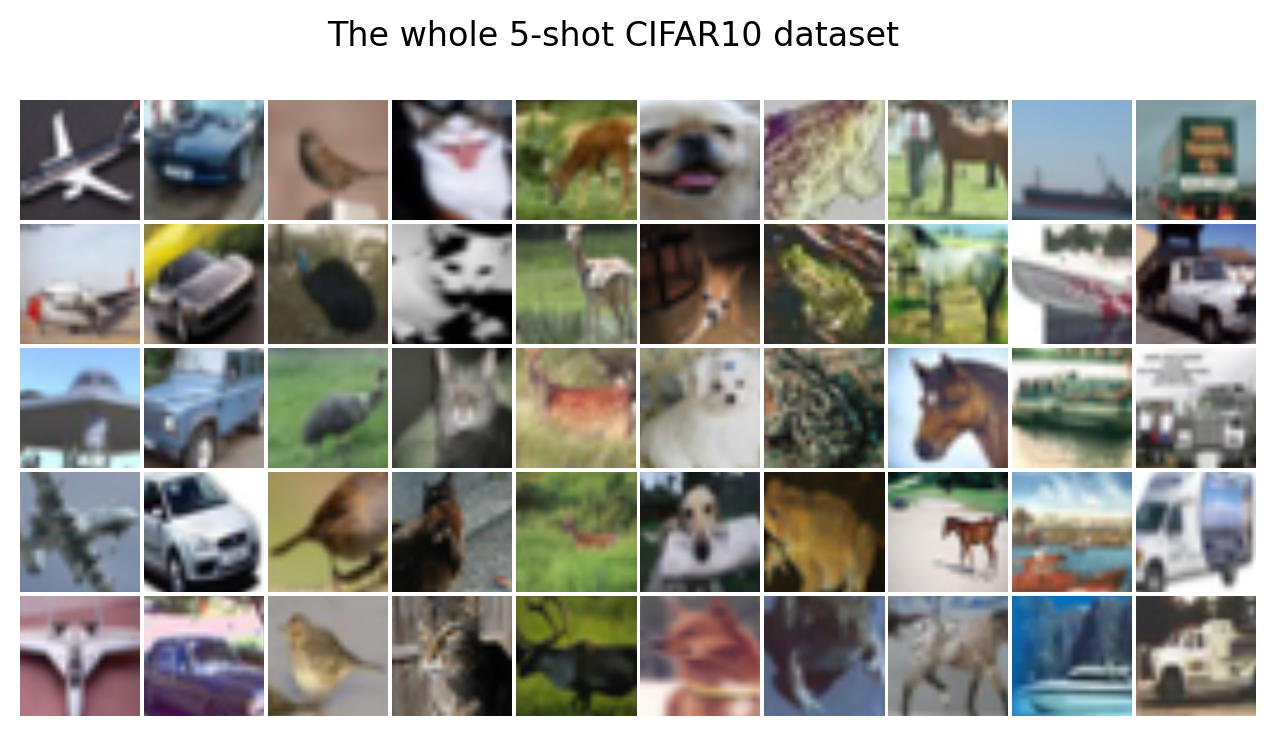

In [ ]:
fig = plt.figure(figsize=(10, 4))
ig = ImageGrid(fig, 111, (5, 10))
for c, cls in enumerate(indices):
  for r, i in enumerate(indices[cls]):
    img, _ = trainset[i]
    ax = ig.axes_column[c][r]
    ax.imshow((img.numpy().transpose([1, 2, 0]) * 127.5 + 127.5).astype(np.uint8))
    ax.set_axis_off()
fig.suptitle('The whole 5-shot CIFAR10 dataset');

In [ ]:
train_5shot = torch.utils.data.Subset(trainset, indices=[i for v in indices.values() for i in v])
len(train_5shot)

50

In [ ]:
sampler = torch.utils.data.RandomSampler(train_5shot, replacement=True, num_samples=256)
loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=32, num_workers=2, sampler=sampler)


### Training The Model

In [ ]:

crit = nn.CrossEntropyLoss()
opti = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
model.train();

In [ ]:
S = 500
def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, S, None)
  return rampup(s, 100, step_lr)

pb_train = display(progress(0, S), display_id=True)
pb_test = display(progress(0, 100), display_id=True)
losses = [[]]
accus_train = [[]]
accus_test = []

steps_per_iter = 512 // loader_train.batch_size

while len(losses) < S:
  for x, t in loader_train:
    x, t = x.to(device), t.to(device)

    logits = model(x)
    loss = crit(logits, t) / steps_per_iter
    loss.backward()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].extend(torch.max(logits, dim=1)[1].cpu().numpy() == t.cpu().numpy())

    if len(losses[-1]) == steps_per_iter:
      losses[-1] = sum(losses[-1])
      losses.append([])
      accus_train[-1] = np.mean(accus_train[-1])
      accus_train.append([])

      # Update learning-rate according to schedule, and stop if necessary
      lr = schedule(len(losses) - 1)
      for param_group in opti.param_groups:
        param_group['lr'] = lr

      opti.step()
      opti.zero_grad()

      pb_train.update(progress(len(losses) - 1, S))
      print(f'\r[Step {len(losses) - 1}] loss={losses[-2]:.2e} '
            f'train accu={accus_train[-2]:.2%} '
            f'test accu={accus_test[-1] if accus_test else 0:.2%} '
            f'(lr={lr:g})', end='', flush=True)

      if len(losses) % 25 == 0:
        accus_test.append(eval_cifar10(model, progressbar=pb_test))
        model.train()

[Step 54] loss=1.11e+00 train accu=56.25% test accu=17.82% (lr=0.00162)

KeyboardInterrupt: 

###Weights Save

In [ ]:
torch.save(model.state_dict(), "./saved/model1.pt")

### Plot

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(accus_train[:-1])
ax2.set_title('training accuracy')
ax3.plot(np.arange(25, 501, 25), accus_test)
ax3.set_title('test accuracy');

## BiT Train

### Download Pretrained Weights for BiT

In [ ]:
def get_weights(bit_variant):
  response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
  response.raise_for_status()
  return np.load(io.BytesIO(response.content))

In [ ]:
weights = get_weights('BiT-M-R50x1')

In [ ]:
weights_cifar10 = get_weights('BiT-M-R50x1-CIFAR10')

In [ ]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

### BiTs


In [ ]:
#BiT Hyperrule

def get_resolution(original_resolution):
  """Takes (H,W) and returns (precrop, crop)."""
  area = original_resolution[0] * original_resolution[1]
  return (160, 128) if area < 96*96 else (512, 480)


known_dataset_sizes = {
  'cifar10': (32, 32),
  'cifar100': (32, 32),
  'oxford_iiit_pet': (224, 224),
  'oxford_flowers102': (224, 224),
  'imagenet2012': (224, 224),
}


def get_resolution_from_dataset(dataset):
  if dataset not in known_dataset_sizes:
    raise ValueError(f"Unsupported dataset {dataset}. Add your own here :)")
  return get_resolution(known_dataset_sizes[dataset])


def get_mixup(dataset_size):
  return 0.0 if dataset_size < 20_000 else 0.1


def get_schedule(dataset_size):
  if dataset_size < 20_000:
    return [100, 200, 300, 400, 500]
  elif dataset_size < 500_000:
    return [500, 3000, 6000, 9000, 10_000]
  else:
    return [500, 6000, 12_000, 18_000, 20_000]


def get_lr(step, dataset_size, base_lr=0.003):
  """Returns learning-rate for `step` or None at the end."""
  supports = get_schedule(dataset_size)
  # Linear warmup
  if step < supports[0]:
    return base_lr * step / supports[0]
  # End of training
  elif step >= supports[-1]:
    return None
  # Staircase decays by factor of 10
  else:
    for s in supports[1:]:
      if s < step:
        base_lr /= 10
    return base_lr

In [ ]:
import collections
import json
import signal
import time

import numpy as np


class Uninterrupt:
  """Context manager to gracefully handle interrupts.

  Use as:
  with Uninterrupt() as u:
      while not u.interrupted:
          # train
  """

  def __init__(self, sigs=(signal.SIGINT, signal.SIGTERM), verbose=False):
    self.sigs = sigs
    self.verbose = verbose
    self.interrupted = False
    self.orig_handlers = None

  def __enter__(self):
    if self.orig_handlers is not None:
      raise ValueError("Can only enter `Uninterrupt` once!")

    self.interrupted = False
    self.orig_handlers = [signal.getsignal(sig) for sig in self.sigs]

    def handler(signum, frame):
      del signum  # unused
      del frame  # unused
      self.release()
      self.interrupted = True
      if self.verbose:
        print("Interruption scheduled...", flush=True)

    for sig in self.sigs:
      signal.signal(sig, handler)

    return self

  def __exit__(self, type_, value, tb):
    self.release()

  def release(self):
    if self.orig_handlers is not None:
      for sig, orig in zip(self.sigs, self.orig_handlers):
        signal.signal(sig, orig)
      self.orig_handlers = None


class Timer:
  """Context timing its scope."""

  def __init__(self, donecb):
    self.cb = donecb

  def __enter__(self):
    self.t0 = time.time()

  def __exit__(self, exc_type, exc_value, traceback):
    t = time.time() - self.t0
    self.cb(t)


class Chrono:
  """Chronometer for poor-man's (but convenient!) profiling."""

  def __init__(self):
    self.timings = collections.OrderedDict()

  def measure(self, what):
    return Timer(lambda t: self._done(what, t))

  def _done(self, what, t):
    self.timings.setdefault(what, []).append(t)

  def times(self, what):
    return self.timings[what]

  def avgtime(self, what, dropfirst=False):
    timings = self.timings[what]
    if dropfirst and len(timings) > 1:
      timings = timings[1:]
    return sum(timings)/len(timings)

  def __str__(self, fmt="{:{w}.5f}", dropfirst=False):
    avgtimes = {k: self.avgtime(k, dropfirst) for k in self.timings}
    l = max(map(len, avgtimes))
    w = max(len(fmt.format(v, w=0)) for v in avgtimes.values())
    avg_by_time = sorted(avgtimes.items(), key=lambda t: t[1], reverse=True)
    return "\n".join(f"{name:{l}s}: " + fmt.format(t, w=w) + "s"
                     for name, t in avg_by_time)


def create_dat(basename, dtype, shape, fillvalue=None, **meta):
  """Creates mem-mapped numpy array plus metadata.

  Creates a data file at `basename` and returns a writeable mem-map backed
  numpy array to it. Can also be passed any json-serializable keys and values
  in `meta`.
  """
  xm = np.memmap(basename, mode="w+", dtype=dtype, shape=shape)
  xa = np.ndarray.__new__(np.ndarray, dtype=dtype, shape=shape, buffer=xm)
  # xa.flush = xm.flush  # Sadly, we can't just add attributes to a numpy array, need to subclass it.

  if fillvalue is not None:
    xa.fill(fillvalue)
    # xa.flush()
    xm.flush()

  meta.setdefault("dtype", np.dtype(dtype).str)
  meta.setdefault("shape", shape)
  json.dump(meta, open(basename + ".json", "w+"))

  return xa


def load_dat(basename, mode="r"):
  """Loads file created via `create_dat` as mem-mapped numpy array.

  Returns a read-only mem-mapped numpy array to file at `basename`.
  If `mode` is set to `'r+'`, the data can be written, too.
  """
  desc = json.load(open(basename + ".json", "r"))
  dtype, shape = desc["dtype"], desc["shape"]
  xm = np.memmap(basename, mode=mode, dtype=dtype, shape=shape)
  xa = np.ndarray.__new__(np.ndarray, dtype=dtype, shape=shape, buffer=xm)
  # xa.flush = xm.flush  # Sadly, we can't just add attributes to a numpy array, need to subclass it.
  return xa

In [ ]:
import argparse
import logging
import logging.config
import os



def argparser(known_models):
  parser = argparse.ArgumentParser(description="Fine-tune BiT-M model.")
  parser.add_argument("--name", required=True,
                      help="Name of this run. Used for monitoring and checkpointing.")
  parser.add_argument("--model", choices=list(known_models),
                      help="Which variant to use; BiT-M gives best results.")
  parser.add_argument("--logdir", required=True,
                      help="Where to log training info (small).")
  parser.add_argument("--bit_pretrained_dir", default='.',
                      help="Where to search for pretrained BiT models.")

  parser.add_argument("--dataset", choices=list(known_dataset_sizes.keys()),
                      help="Choose the dataset. It should be easy to add your own! "
                      "Don't forget to set --datadir if necessary.")
  parser.add_argument("--examples_per_class", type=int, default=None,
                      help="For the few-shot variant, use this many examples "
                      "per class only.")
  parser.add_argument("--examples_per_class_seed", type=int, default=0,
                      help="Random seed for selecting examples.")

  parser.add_argument("--batch", type=int, default=512,
                      help="Batch size.")
  parser.add_argument("--batch_split", type=int, default=1,
                      help="Number of batches to compute gradient on before updating weights.")
  parser.add_argument("--base_lr", type=float, default=0.003,
                      help="Base learning-rate for fine-tuning. Most likely default is best.")
  parser.add_argument("--eval_every", type=int, default=None,
                      help="Run prediction on validation set every so many steps."
                      "Will always run one evaluation at the end of training.")
  return parser


def setup_logger(logdir, name):
  """Creates and returns a fancy logger."""
  # return logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(message)s")
  # Why is setting up proper logging so !@?#! ugly?
  os.makedirs(os.path.join(logdir, name), exist_ok=True)
  logging.config.dictConfig({
      "version": 1,
      "disable_existing_loggers": False,
      "formatters": {
          "standard": {
              "format": "%(asctime)s [%(levelname)s] %(name)s: %(message)s"
          },
      },
      "handlers": {
          "stderr": {
              "level": "INFO",
              "formatter": "standard",
              "class": "logging.StreamHandler",
              "stream": "ext://sys.stderr",
          },
          "logfile": {
              "level": "DEBUG",
              "formatter": "standard",
              "class": "logging.FileHandler",
              "filename": os.path.join(logdir, name, "train.log"),
              "mode": "a",
          }
      },
      "loggers": {
          "": {
              "handlers": ["stderr", "logfile"],
              "level": "DEBUG",
              "propagate": True
          },
      }
  })
  logger = logging.getLogger(__name__)
  logger.flush = lambda: [h.flush() for h in logger.handlers]
#  logger.info(args)
  return logger

In [ ]:
#BiT fewshot

from collections import *
from functools import *
import random
import sys

import torch
import torchvision as tv


class AddIndexIter(torch.utils.data.dataloader._SingleProcessDataLoaderIter):
  def _next_data(self):
    index = self._next_index()  # may raise StopIteration
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
    if self._pin_memory:
      data = torch.utils.data._utils.pin_memory.pin_memory(data)
    return index, data


def find_indices_loader(loader, n_shots, n_classes):
  per_label_indices = defaultdict(partial(deque, maxlen=n_shots))

  for ibatch, (indices, (images, labels)) in enumerate(AddIndexIter(loader)):
    for idx, lbl in zip(indices, labels):
      per_label_indices[lbl.item()].append(idx)

      findings = sum(map(len, per_label_indices.values()))
      if findings == n_shots * n_classes:
        return per_label_indices
  raise RuntimeError("Unable to find enough examples!")


def find_fewshot_indices(dataset, n_shots):
  n_classes = len(dataset.classes)

  orig_transform = dataset.transform
  dataset.transform = tv.transforms.Compose([
      tv.transforms.CenterCrop(1),
      tv.transforms.ToTensor()
  ])

  # TODO(lbeyer): if dataset isinstance DatasetFolder, we can (maybe?) do much better!

  loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)

  per_label_indices = find_indices_loader(loader, n_shots, n_classes)
  all_indices = [i for indices in per_label_indices.values() for i in indices]
  random.shuffle(all_indices)

  dataset.transform = orig_transform
  return all_indices



#  dataset = tv.datasets.ImageFolder(sys.argv[2], preprocess)
#  all_indices = find_fewshot_indices(dataset, int(sys.argv[1]))
#  for i in all_indices:
#      print(i)

In [ ]:
#From BiT

from os.path import join as pjoin  # pylint: disable=g-importing-member
import time

import numpy as np
import torch
import torchvision as tv


def topk(output, target, ks=(1,)):
  """Returns one boolean vector for each k, whether the target is within the output's top-k."""
  _, pred = output.topk(max(ks), 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  return [correct[:k].max(0)[0] for k in ks]


def recycle(iterable):
  """Variant of itertools.cycle that does not save iterates."""
  while True:
    for i in iterable:
      yield i


def mktrainval(dataset, datadir, logger, batch, batch_split, workers, examples_per_class = None):
  """Returns train and validation datasets."""
  precrop, crop = get_resolution_from_dataset(dataset)
  train_tx = tv.transforms.Compose([
      tv.transforms.Resize((precrop, precrop)),
      tv.transforms.RandomCrop((crop, crop)),
      tv.transforms.RandomHorizontalFlip(),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])
  val_tx = tv.transforms.Compose([
      tv.transforms.Resize((crop, crop)),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  if dataset == "cifar10":
    train_set = tv.datasets.CIFAR10(datadir, transform=train_tx, train=True, download=True)
    valid_set = tv.datasets.CIFAR10(datadir, transform=val_tx, train=False, download=True)
  elif dataset == "cifar100":
    train_set = tv.datasets.CIFAR100(datadir, transform=train_tx, train=True, download=True)
    valid_set = tv.datasets.CIFAR100(datadir, transform=val_tx, train=False, download=True)
  elif dataset == "imagenet2012":
    train_set = tv.datasets.ImageFolder(pjoin(datadir, "train"), train_tx)
    valid_set = tv.datasets.ImageFolder(pjoin(datadir, "val"), val_tx)
  else:
    raise ValueError(f"Sorry, we have not spent time implementing the "
                     f"{dataset} dataset in the PyTorch codebase. "
                     f"In principle, it should be easy to add :)")

  if examples_per_class is not None:
    logger.info(f"Looking for {examples_per_class} images per class...")
    indices = find_fewshot_indices(train_set, examples_per_class)
    train_set = torch.utils.data.Subset(train_set, indices=indices)

  logger.info(f"Using a training set with {len(train_set)} images.")
  logger.info(f"Using a validation set with {len(valid_set)} images.")

  micro_batch_size = batch // batch_split

  valid_loader = torch.utils.data.DataLoader(
      valid_set, batch_size=micro_batch_size, shuffle=False,
      num_workers=workers, pin_memory=True, drop_last=False)

  if micro_batch_size <= len(train_set):
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=micro_batch_size, shuffle=True,
        num_workers=workers, pin_memory=True, drop_last=False)
  else:
    # In the few-shot cases, the total dataset size might be smaller than the batch-size.
    # In these cases, the default sampler doesn't repeat, so we need to make it do that
    # if we want to match the behaviour from the paper.
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=micro_batch_size, num_workers=workers, pin_memory=True,
        sampler=torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=micro_batch_size))

  return train_set, valid_set, train_loader, valid_loader


def run_eval(model, data_loader, device, chrono, logger, step):
  # switch to evaluate mode
  model.eval()

  logger.info("Running validation...")
  logger.flush()

  all_c, all_top1, all_top5 = [], [], []
  end = time.time()
  for b, (x, y) in enumerate(data_loader):
    with torch.no_grad():
      x = x.to(device, non_blocking=True)
      y = y.to(device, non_blocking=True)

      # measure data loading time
      chrono._done("eval load", time.time() - end)

      # compute output, measure accuracy and record loss.
      with chrono.measure("eval fprop"):
        logits = model(x)
        c = torch.nn.CrossEntropyLoss(reduction='none')(logits, y)
        top1, top5 = topk(logits, y, ks=(1, 5))
        all_c.extend(c.cpu())  # Also ensures a sync point.
        all_top1.extend(top1.cpu())
        all_top5.extend(top5.cpu())

    # measure elapsed time
    end = time.time()

  model.train()
  logger.info(f"Validation@{step} loss {np.mean(all_c):.5f}, "
              f"top1 {np.mean(all_top1):.2%}, "
              f"top5 {np.mean(all_top5):.2%}")
  logger.flush()
  return all_c, all_top1, all_top5


def mixup_data(x, y, l):
  """Returns mixed inputs, pairs of targets, and lambda"""
  indices = torch.randperm(x.shape[0]).to(x.device)

  mixed_x = l * x + (1 - l) * x[indices]
  y_a, y_b = y, y[indices]
  return mixed_x, y_a, y_b


def mixup_criterion(criterion, pred, y_a, y_b, l):
  return l * criterion(pred, y_a) + (1 - l) * criterion(pred, y_b)



### Load Model

In [ ]:
KNOWN_MODELS = OrderedDict([
    ('LinNet-R50x1', (lambda *a, **kw: LinNet([3, 4, 6, 3], 1, *a, **kw), weights)),
])



In [ ]:
def get_model(model_name,  head_size, load_weights = True):
  """ Returns The Zero Headed, Loaded Model Here"""

  model = KNOWN_MODELS[model_name][0](head_size = head_size, zero_head = True)
  model.load_from(KNOWN_MODELS[model_name][1])


  return model


In [ ]:
#get heads from dataset
heads = 100
model = get_model('LinNet-R50x1', head_size = heads)

### Freeze Model


In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if (hasattr(unit,"freeze") and hasattr(unit,"pretrained")):
      if unit.pretrained:
        unit.freeze()
        unit.freezed = True

### Melt Model

In [ ]:
"""for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    if hasattr(unit,"melt"):
      unit.melt()
      unit.freezed = False"""

### Check Weights Freezing

In [ ]:
for bname, block in model.body.named_children():
  for uname, unit in block.unit.named_children():
    #unit.load_from(weights, prefix=f'resnet/{bname}/{uname}/')
    t1 = tf2th(weights[f'resnet/{bname}/{uname}/' + 'a/standardized_conv2d/kernel']).to(device)
    print(torch.equal(unit.conv1.weight,t1))
    print(t1.shape)
    print(unit.conv1.weight.shape)

True
torch.Size([64, 64, 1, 1])
torch.Size([64, 64, 1, 1])
True
torch.Size([64, 256, 1, 1])
torch.Size([64, 256, 1, 1])
True
torch.Size([64, 256, 1, 1])
torch.Size([64, 256, 1, 1])
True
torch.Size([128, 256, 1, 1])
torch.Size([128, 256, 1, 1])
True
torch.Size([128, 512, 1, 1])
torch.Size([128, 512, 1, 1])
True
torch.Size([128, 512, 1, 1])
torch.Size([128, 512, 1, 1])
True
torch.Size([128, 512, 1, 1])
torch.Size([128, 512, 1, 1])
True
torch.Size([256, 512, 1, 1])
torch.Size([256, 512, 1, 1])
True
torch.Size([256, 1024, 1, 1])
torch.Size([256, 1024, 1, 1])
True
torch.Size([256, 1024, 1, 1])
torch.Size([256, 1024, 1, 1])
True
torch.Size([256, 1024, 1, 1])
torch.Size([256, 1024, 1, 1])
True
torch.Size([256, 1024, 1, 1])
torch.Size([256, 1024, 1, 1])
True
torch.Size([256, 1024, 1, 1])
torch.Size([256, 1024, 1, 1])
True
torch.Size([512, 1024, 1, 1])
torch.Size([512, 1024, 1, 1])
True
torch.Size([512, 2048, 1, 1])
torch.Size([512, 2048, 1, 1])
True
torch.Size([512, 2048, 1, 1])
torch.Size([51

### Train

In [ ]:
def train(model, logdir, name, dataset, datadir, batch, batch_split, workers, base_lr, eval_every = 25, save = True):
  logger = setup_logger(logdir = logdir, name = name)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  logger.info(f"Going to train on {device}")


  train_set, valid_set, train_loader, valid_loader = mktrainval(dataset, datadir, logger, batch, batch_split, workers)

  logger.info("Moving model onto all GPUs")
  model = torch.nn.DataParallel(model)

  # Optionally resume from a checkpoint.
  # Load it to CPU first as we'll move the model to GPU later.
  # This way, we save a little bit of GPU memory when loading.
  step = 0

  # Note: no weight-decay!
  optim = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

  savename = pjoin(logdir, name, "bit.pth.tar")
  try:
    logger.info(f"Model will be saved in '{savename}'")
    checkpoint = torch.load(savename, map_location="cpu")
    logger.info(f"Found saved model to resume from at '{savename}'")

    step = checkpoint["step"]
    model.load_state_dict(checkpoint["model"])
    optim.load_state_dict(checkpoint["optim"])
    logger.info(f"Resumed at step {step}")
  except FileNotFoundError:
    logger.info("Fine-tuning from BiT")

  model = model.to(device)
  optim.zero_grad()

  model.train()
  mixup = get_mixup(len(train_set))
  cri = torch.nn.CrossEntropyLoss().to(device)

  logger.info("Starting training!")
  chrono = Chrono()
  accum_steps = 0
  mixup_l = np.random.beta(mixup, mixup) if mixup > 0 else 1
  end = time.time()


  with Uninterrupt() as u:
    for x, y in recycle(train_loader):
      # measure data loading time, which is spent in the `for` statement.
      chrono._done("load", time.time() - end)

      if u.interrupted:
        break

      # Schedule sending to GPU(s)
      x = x.to(device, non_blocking=True)
      y = y.to(device, non_blocking=True)

      # Update learning-rate, including stop training if over.
      lr = get_lr(step, len(train_set), base_lr)
      if lr is None:
        break
      for param_group in optim.param_groups:
        param_group["lr"] = lr

      if mixup > 0.0:
        x, y_a, y_b = mixup_data(x, y, mixup_l)

      # compute output
      with chrono.measure("fprop"):
        logits = model(x)
        if mixup > 0.0:
          c = mixup_criterion(cri, logits, y_a, y_b, mixup_l)
        else:
          c = cri(logits, y)
        c_num = float(c.data.cpu().numpy())  # Also ensures a sync point.

      # Accumulate grads
      with chrono.measure("grads"):
        (c / batch_split).backward()
        accum_steps += 1

      accstep = f" ({accum_steps}/{batch_split})" if batch_split > 1 else ""
      logger.info(f"[step {step}{accstep}]: loss={c_num:.5f} (lr={lr:.1e})")  # pylint: disable=logging-format-interpolation
      logger.flush()

      # Update params
      if accum_steps == batch_split:
        with chrono.measure("update"):
          optim.step()
          optim.zero_grad()
        step += 1
        accum_steps = 0
        # Sample new mixup ratio for next batch
        mixup_l = np.random.beta(mixup, mixup) if mixup > 0 else 1

        # Run evaluation and save the model.
        if eval_every and step % eval_every == 0:
          run_eval(model, valid_loader, device, chrono, logger, step)
          if save:
            torch.save({
                "step": step,
                "model": model.state_dict(),
                "optim" : optim.state_dict(),
            }, savename)

      end = time.time()

    # Final eval at end of training.
    run_eval(model, valid_loader, device, chrono, logger, step='end')

  logger.info(f"Timings:\n{chrono}")

### Training

In [ ]:
train(model, logdir = './log2', name = 'run2', dataset = 'cifar100', datadir = './data', batch = 64, batch_split = 1, workers = 2, base_lr = 0.003, eval_every = None, save = True)

2024-06-13 09:33:13,264 [INFO] __main__: Going to train on cuda:0


Files already downloaded and verified
Files already downloaded and verified


2024-06-13 09:33:15,160 [INFO] __main__: Using a training set with 50000 images.
2024-06-13 09:33:15,162 [INFO] __main__: Using a validation set with 10000 images.
2024-06-13 09:33:15,164 [INFO] __main__: Moving model onto all GPUs
2024-06-13 09:33:15,170 [INFO] __main__: Model will be saved in './log2/run2/bit.pth.tar'
2024-06-13 09:33:15,173 [INFO] __main__: Fine-tuning from BiT
2024-06-13 09:33:15,179 [INFO] __main__: Starting training!
2024-06-13 09:33:16,358 [INFO] __main__: [step 0]: loss=4.26563 (lr=0.0e+00)
2024-06-13 09:33:18,208 [INFO] __main__: [step 1]: loss=4.46214 (lr=6.0e-06)
2024-06-13 09:33:20,075 [INFO] __main__: [step 2]: loss=4.48093 (lr=1.2e-05)
2024-06-13 09:33:21,960 [INFO] __main__: [step 3]: loss=4.43808 (lr=1.8e-05)
2024-06-13 09:33:23,844 [INFO] __main__: [step 4]: loss=4.28513 (lr=2.4e-05)
2024-06-13 09:33:25,745 [INFO] __main__: [step 5]: loss=4.00643 (lr=3.0e-05)
2024-06-13 09:33:27,661 [INFO] __main__: [step 6]: loss=3.99270 (lr=3.6e-05)
2024-06-13 09:33:

#DO NOT RUN

## Part 1

In [ ]:
"""
from collections import OrderedDict  # pylint: disable=g-importing-member

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

class StdConv2d(nn.Conv2d):

  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding,
                    self.dilation, self.groups)


def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                   padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                   padding=0, bias=bias)


def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW."""
  if conv_weights.ndim == 4:
    conv_weights = conv_weights.transpose([3, 2, 0, 1])
  return torch.from_numpy(conv_weights)


class PreActBottleneck(nn.Module):
  """#Pre-activation (v2) bottleneck block.

  #Follows the implementation of "Identity Mappings in Deep Residual Networks":
  #https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

#  Except it puts the stride on 3x3 conv when available.
  """

  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original code has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
    out = self.relu(self.gn1(x))

    # Residual branch
    residual = x
    if hasattr(self, 'downsample'):
      residual = self.downsample(out)

    # Unit's branch
    out = self.conv1(out)
    out = self.conv2(self.relu(self.gn2(out)))
    out = self.conv3(self.relu(self.gn3(out)))

    return out + residual

  def load_from(self, weights, prefix=''):
    convname = 'standardized_conv2d'
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[f'{prefix}a/{convname}/kernel']))
      self.conv2.weight.copy_(tf2th(weights[f'{prefix}b/{convname}/kernel']))
      self.conv3.weight.copy_(tf2th(weights[f'{prefix}c/{convname}/kernel']))
      self.gn1.weight.copy_(tf2th(weights[f'{prefix}a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[f'{prefix}b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[f'{prefix}c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[f'{prefix}a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[f'{prefix}b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[f'{prefix}c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        w = weights[f'{prefix}a/proj/{convname}/kernel']
        self.downsample.weight.copy_(tf2th(w))

"""
"""
class ResNetV2(nn.Module):

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    # The following will be unreadable if we split lines.
    # pylint: disable=line-too-long
    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('pad', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))
    # pylint: enable=line-too-long

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))

  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))  # pylint: disable=line-too-long
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))  # pylint: disable=line-too-long
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')


KNOWN_MODELS = OrderedDict([
    ('BiT-M-R50x1', lambda *a, **kw: ResNetV2([3, 4, 6, 3], 1, *a, **kw)),
    ('BiT-M-R50x3', lambda *a, **kw: ResNetV2([3, 4, 6, 3], 3, *a, **kw)),
    ('BiT-M-R101x1', lambda *a, **kw: ResNetV2([3, 4, 23, 3], 1, *a, **kw)),
    ('BiT-M-R101x3', lambda *a, **kw: ResNetV2([3, 4, 23, 3], 3, *a, **kw)),
    ('BiT-M-R152x2', lambda *a, **kw: ResNetV2([3, 8, 36, 3], 2, *a, **kw)),
    ('BiT-M-R152x4', lambda *a, **kw: ResNetV2([3, 8, 36, 3], 4, *a, **kw)),
    ('BiT-S-R50x1', lambda *a, **kw: ResNetV2([3, 4, 6, 3], 1, *a, **kw)),
    ('BiT-S-R50x3', lambda *a, **kw: ResNetV2([3, 4, 6, 3], 3, *a, **kw)),
    ('BiT-S-R101x1', lambda *a, **kw: ResNetV2([3, 4, 23, 3], 1, *a, **kw)),
    ('BiT-S-R101x3', lambda *a, **kw: ResNetV2([3, 4, 23, 3], 3, *a, **kw)),
    ('BiT-S-R152x2', lambda *a, **kw: ResNetV2([3, 8, 36, 3], 2, *a, **kw)),
    ('BiT-S-R152x4', lambda *a, **kw: ResNetV2([3, 8, 36, 3], 4, *a, **kw)),
])"""

In [ ]:
"""
class PreActConv(nn.Module):
  """"""Pre-activation (v2) bottleneck block.

  Follows the implementation of "Identity Mappings in Deep Residual Networks":
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
"""
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original code has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)


  def forward(self, x):
    out = self.relu(self.gn1(x))

    # Unit's branch
    out = self.conv1(out)
    out = self.conv2(self.relu(self.gn2(out)))
    out = self.conv3(self.relu(self.gn3(out)))

    return out


class ConvWithLin(nn.Module):
  def __init__(self, lcin, cin, cout = None, cmid = None, lcout = None, stride=1, block_unit = 1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4
    lcout = lcout or lcin

    #self.unit = PreActConv(cin=cin,cout=cout,cmid=cmid,stride=stride)
    if lcin != cin:
      self.projin = conv1x1(lcin,cin,stride)

    self.unit = nn.Sequential(OrderedDict(
            [('unit01', PreActConv(cin=cin, cout=cout, cmid=cmid, stride=stride))] +
            [(f'unit{i:02d}', PreActConv(cin=cout, cout=cout, cmid=cmid)) for i in range(2, block_unit + 1)],
        ))
    if lcout != cout:
      self.projout = conv1x1(cout, lcout, stride)
    if lcout != lcin:
      self.linproj = conv1x1(lcin, lcout, stride)


  def forward(self, x):
    if hasattr(self, 'projin'):
      out = self.projin(x)
    else:
      out = x

    out = self.unit(out)

    if hasattr(self, 'projout'):
      out = self.projout(out)
    if hasattr(self, 'linproj'):
      x = self.linproj(x)

    out = torch.add(out,x)

#    if hasattr(self, 'outunit'):
#      out = self.outunit(out)

    return out


class LinNet(nn.Module):
  """#Implementation of Pre-activation (v2) ResNet mode."""
"""
  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    # The following will be unreadable if we split lines.
    # pylint: disable=line-too-long
    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('pad', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', ConvWithLin(lcin = 64*wf, lcout=512*wf, cin=64*wf, cout= 256*wf, cmid=64*wf, block_unit = block_units[0])),
        ('block2', ConvWithLin(lcin = 512*wf, lcout=512*wf, cin=256*wf, cout= 512*wf, cmid=128*wf, block_unit = block_units[1])),
        ('block3', ConvWithLin(lcin = 512*wf, lcout=2048*wf, cin=512*wf, cout= 1024*wf, cmid=256*wf, block_unit = block_units[2])),
        ('block4', ConvWithLin(lcin = 2048*wf, lcout=2048*wf, cin=1024*wf, cout= 2048*wf, cmid=512*wf, block_unit = block_units[3])),
    ]))
    # pylint: enable=line-too-long

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))

  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]




In [ ]:
precrop, crop = (160, 128)
train_tx = tv.transforms.Compose([
      tv.transforms.Resize((precrop, precrop)),
      tv.transforms.RandomCrop((crop, crop)),
      tv.transforms.RandomHorizontalFlip(),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])
val_tx = tv.transforms.Compose([
      tv.transforms.Resize((crop, crop)),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

train_set = tv.datasets.CIFAR10(root = "./data", transform=train_tx, train=True, download=True)
valid_set = tv.datasets.CIFAR10(root = "./data", transform=val_tx, train=False, download=True)

valid_loader = torch.utils.data.DataLoader(
      valid_set, batch_size=64, shuffle=False,
      num_workers=2, pin_memory=True, drop_last=False)
train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=64, shuffle=True,
        num_workers=2, pin_memory=True, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = LinNet(LinNet.BLOCK_UNITS['r50'], width_factor=1, head_size=10)  # NOTE: No new head.
model.load_from(weights_cifar10)
model.to(device);

In [ ]:
crit = nn.CrossEntropyLoss()
opti = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-6)
model.train();

In [ ]:
S = 30
def schedule(s):
  step_lr = stairs(s, 3e-3, 10, 3e-4, 20, 3e-5, 25, 3e-6, S, None)
  return rampup(s, 2, step_lr)

pb_train = display(progress(0, S), display_id=True)
pb_test = display(progress(0, 100), display_id=True)


losses = [[]]
accus_train = [[]]
accus_test = []

steps_per_iter = 50000 // loader_train.batch_size

pb_step = display(progress(0, steps_per_iter), display_id=True)

while len(losses) < S:
  for x, t in loader_train:
    x, t = x.to(device), t.to(device)

    logits = model(x)
    loss = crit(logits, t) / steps_per_iter
    loss.backward()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].extend(torch.max(logits, dim=1)[1].cpu().numpy() == t.cpu().numpy())

    if len(losses[-1])%10 == 0:
      pb_train.update(progress(len(losses[-1]) - 1, S))

    if len(losses[-1]) == steps_per_iter:
      losses[-1] = sum(losses[-1])
      losses.append([])
      accus_train[-1] = np.mean(accus_train[-1])
      accus_train.append([])

      # Update learning-rate according to schedule, and stop if necessary
      lr = schedule(len(losses) - 1)
      for param_group in opti.param_groups:
        param_group['lr'] = lr

      opti.step()
      opti.zero_grad()

      pb_train.update(progress(len(losses) - 1, S))
      print(f'\r[Step {len(losses) - 1}] loss={losses[-2]:.2e} '
            f'train accu={accus_train[-2]:.2%} '
            f'test accu={accus_test[-1] if accus_test else 0:.2%} '
            f'(lr={lr:g})', end='', flush=True)

      if len(losses) % 25 == 0:
        accus_test.append(eval_cifar10(model, progressbar=pb_test))
        model.train()

KeyboardInterrupt: 

Train2

In [ ]:
model = LinNet(LinNet.BLOCK_UNITS['r50'], width_factor=1, head_size=10)  # NOTE: No new head.
model.load_from(weights_cifar10)
model.to(device);

In [ ]:
precrop, crop = (160, 128)
train_tx = tv.transforms.Compose([
      tv.transforms.Resize((precrop, precrop)),
      tv.transforms.RandomCrop((crop, crop)),
      tv.transforms.RandomHorizontalFlip(),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])
val_tx = tv.transforms.Compose([
      tv.transforms.Resize((crop, crop)),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

#transform_train = T.Compose( [T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )
#transform_test = T.Compose( [T.ToTensor(), T.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )] )

train_set = tv.datasets.CIFAR10('./data', train=True, download=True, transform=train_tx )
test_set = tv.datasets.CIFAR10('./data', train=False, download=True, transform=val_tx )

classes = train_set.classes

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#learning_rate = 1e-3
batch_size = 32
num_epochs = 10

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)



In [ ]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):

    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)

    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))

    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

In [ ]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
  if s < peak_s:  # Warmup
    return s/peak_s * peak_lr
  else:
    return peak_lr

def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, 500, None)
  return rampup(s, 100, step_lr)

In [ ]:
S = 30
def schedule(s):
  step_lr = stairs(s, 3e-3, 10, 3e-4, 20, 3e-5, 25, 3e-6, S, None)
  return rampup(s, 2, step_lr)

In [ ]:
from statistics import mean

optim =  torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=1e-6)

loss_fn = nn.CrossEntropyLoss()

def train(optimizer, model, num_epochs = 30, first_epoch = 1):

    train_losses = []
    test_losses = []

    best_test_acc = 0

    steps_per_iter = 50000 // train_loader.batch_size

    for epoch in range(first_epoch, first_epoch + num_epochs):
        lr = schedule(epoch)
        for param_group in opti.param_groups:
          param_group['lr'] = lr
        print('Epoch', epoch)

        model.train()
        progress = ProgressMonitor(length=len(train_set))

        correct_train = 0
        batch_losses = []

        for batch, targets in train_loader:

            batch = batch.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(batch)

            loss = loss_fn(outputs, targets)/steps_per_iter
            loss.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()


            batch_losses.append(loss.item()*steps_per_iter)

            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)
            progress.update(batch.shape[0], mean(batch_losses) )

        #scheduler.step()

        train_losses.append( mean(batch_losses))

        model.eval()

        y_pred = []

        correct_test = 0

        with torch.no_grad():

            for batch, targets in test_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                outputs = model(batch)

                # calculate the loss
                loss = loss_fn(outputs, targets)

                # save predictions
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )

                # accumulate correct count
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)


        # Calculate accuracy
        train_acc = correct_train.item() / train_set.data.shape[0]
        test_acc = correct_test.item() / test_set.data.shape[0]


        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%'.format(float(test_acc) * 100), end='')

        # Save the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save( model.state_dict(), 'best_model.pt' )
            print( ' --> Best model saved!\n' )


    return train_losses, test_losses, y_pred

In [ ]:
train(optim, model=model)#, train_loader=train_loader,valid_loader=test_loader)

Epoch 1


Loss: 2.2900 10208 / 50000,10208


KeyboardInterrupt: 

## CIFAR-100 Train

### LinNet Warmstarted With BiT-r50x1 CIFAR-10 weights : Alternative Pretrained Weights Freezed

### BiTs


In [ ]:
#BiT Hyperrule

def get_resolution(original_resolution):
  """Takes (H,W) and returns (precrop, crop)."""
  area = original_resolution[0] * original_resolution[1]
  return (160, 128) if area < 96*96 else (512, 480)


known_dataset_sizes = {
  'cifar10': (32, 32),
  'cifar100': (32, 32),
  'oxford_iiit_pet': (224, 224),
  'oxford_flowers102': (224, 224),
  'imagenet2012': (224, 224),
}


def get_resolution_from_dataset(dataset):
  if dataset not in known_dataset_sizes:
    raise ValueError(f"Unsupported dataset {dataset}. Add your own here :)")
  return get_resolution(known_dataset_sizes[dataset])


def get_mixup(dataset_size):
  return 0.0 if dataset_size < 20_000 else 0.1


def get_schedule(dataset_size):
  if dataset_size < 20_000:
    return [100, 200, 300, 400, 500]
  elif dataset_size < 500_000:
    return [500, 3000, 6000, 9000, 10_000]
  else:
    return [500, 6000, 12_000, 18_000, 20_000]


def get_lr(step, dataset_size, base_lr=0.003):
  """Returns learning-rate for `step` or None at the end."""
  supports = get_schedule(dataset_size)
  # Linear warmup
  if step < supports[0]:
    return base_lr * step / supports[0]
  # End of training
  elif step >= supports[-1]:
    return None
  # Staircase decays by factor of 10
  else:
    for s in supports[1:]:
      if s < step:
        base_lr /= 10
    return base_lr

In [ ]:
import collections
import json
import signal
import time

import numpy as np


class Uninterrupt:
  """Context manager to gracefully handle interrupts.

  Use as:
  with Uninterrupt() as u:
      while not u.interrupted:
          # train
  """

  def __init__(self, sigs=(signal.SIGINT, signal.SIGTERM), verbose=False):
    self.sigs = sigs
    self.verbose = verbose
    self.interrupted = False
    self.orig_handlers = None

  def __enter__(self):
    if self.orig_handlers is not None:
      raise ValueError("Can only enter `Uninterrupt` once!")

    self.interrupted = False
    self.orig_handlers = [signal.getsignal(sig) for sig in self.sigs]

    def handler(signum, frame):
      del signum  # unused
      del frame  # unused
      self.release()
      self.interrupted = True
      if self.verbose:
        print("Interruption scheduled...", flush=True)

    for sig in self.sigs:
      signal.signal(sig, handler)

    return self

  def __exit__(self, type_, value, tb):
    self.release()

  def release(self):
    if self.orig_handlers is not None:
      for sig, orig in zip(self.sigs, self.orig_handlers):
        signal.signal(sig, orig)
      self.orig_handlers = None


class Timer:
  """Context timing its scope."""

  def __init__(self, donecb):
    self.cb = donecb

  def __enter__(self):
    self.t0 = time.time()

  def __exit__(self, exc_type, exc_value, traceback):
    t = time.time() - self.t0
    self.cb(t)


class Chrono:
  """Chronometer for poor-man's (but convenient!) profiling."""

  def __init__(self):
    self.timings = collections.OrderedDict()

  def measure(self, what):
    return Timer(lambda t: self._done(what, t))

  def _done(self, what, t):
    self.timings.setdefault(what, []).append(t)

  def times(self, what):
    return self.timings[what]

  def avgtime(self, what, dropfirst=False):
    timings = self.timings[what]
    if dropfirst and len(timings) > 1:
      timings = timings[1:]
    return sum(timings)/len(timings)

  def __str__(self, fmt="{:{w}.5f}", dropfirst=False):
    avgtimes = {k: self.avgtime(k, dropfirst) for k in self.timings}
    l = max(map(len, avgtimes))
    w = max(len(fmt.format(v, w=0)) for v in avgtimes.values())
    avg_by_time = sorted(avgtimes.items(), key=lambda t: t[1], reverse=True)
    return "\n".join(f"{name:{l}s}: " + fmt.format(t, w=w) + "s"
                     for name, t in avg_by_time)


def create_dat(basename, dtype, shape, fillvalue=None, **meta):
  """Creates mem-mapped numpy array plus metadata.

  Creates a data file at `basename` and returns a writeable mem-map backed
  numpy array to it. Can also be passed any json-serializable keys and values
  in `meta`.
  """
  xm = np.memmap(basename, mode="w+", dtype=dtype, shape=shape)
  xa = np.ndarray.__new__(np.ndarray, dtype=dtype, shape=shape, buffer=xm)
  # xa.flush = xm.flush  # Sadly, we can't just add attributes to a numpy array, need to subclass it.

  if fillvalue is not None:
    xa.fill(fillvalue)
    # xa.flush()
    xm.flush()

  meta.setdefault("dtype", np.dtype(dtype).str)
  meta.setdefault("shape", shape)
  json.dump(meta, open(basename + ".json", "w+"))

  return xa


def load_dat(basename, mode="r"):
  """Loads file created via `create_dat` as mem-mapped numpy array.

  Returns a read-only mem-mapped numpy array to file at `basename`.
  If `mode` is set to `'r+'`, the data can be written, too.
  """
  desc = json.load(open(basename + ".json", "r"))
  dtype, shape = desc["dtype"], desc["shape"]
  xm = np.memmap(basename, mode=mode, dtype=dtype, shape=shape)
  xa = np.ndarray.__new__(np.ndarray, dtype=dtype, shape=shape, buffer=xm)
  # xa.flush = xm.flush  # Sadly, we can't just add attributes to a numpy array, need to subclass it.
  return xa

In [ ]:
import argparse
import logging
import logging.config
import os



def argparser(known_models):
  parser = argparse.ArgumentParser(description="Fine-tune BiT-M model.")
  parser.add_argument("--name", required=True,
                      help="Name of this run. Used for monitoring and checkpointing.")
  parser.add_argument("--model", choices=list(known_models),
                      help="Which variant to use; BiT-M gives best results.")
  parser.add_argument("--logdir", required=True,
                      help="Where to log training info (small).")
  parser.add_argument("--bit_pretrained_dir", default='.',
                      help="Where to search for pretrained BiT models.")

  parser.add_argument("--dataset", choices=list(known_dataset_sizes.keys()),
                      help="Choose the dataset. It should be easy to add your own! "
                      "Don't forget to set --datadir if necessary.")
  parser.add_argument("--examples_per_class", type=int, default=None,
                      help="For the few-shot variant, use this many examples "
                      "per class only.")
  parser.add_argument("--examples_per_class_seed", type=int, default=0,
                      help="Random seed for selecting examples.")

  parser.add_argument("--batch", type=int, default=512,
                      help="Batch size.")
  parser.add_argument("--batch_split", type=int, default=1,
                      help="Number of batches to compute gradient on before updating weights.")
  parser.add_argument("--base_lr", type=float, default=0.003,
                      help="Base learning-rate for fine-tuning. Most likely default is best.")
  parser.add_argument("--eval_every", type=int, default=None,
                      help="Run prediction on validation set every so many steps."
                      "Will always run one evaluation at the end of training.")
  return parser


def setup_logger(logdir, name):
  """Creates and returns a fancy logger."""
  # return logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(message)s")
  # Why is setting up proper logging so !@?#! ugly?
  os.makedirs(os.path.join(logdir, name), exist_ok=True)
  logging.config.dictConfig({
      "version": 1,
      "disable_existing_loggers": False,
      "formatters": {
          "standard": {
              "format": "%(asctime)s [%(levelname)s] %(name)s: %(message)s"
          },
      },
      "handlers": {
          "stderr": {
              "level": "INFO",
              "formatter": "standard",
              "class": "logging.StreamHandler",
              "stream": "ext://sys.stderr",
          },
          "logfile": {
              "level": "DEBUG",
              "formatter": "standard",
              "class": "logging.FileHandler",
              "filename": os.path.join(logdir, name, "train.log"),
              "mode": "a",
          }
      },
      "loggers": {
          "": {
              "handlers": ["stderr", "logfile"],
              "level": "DEBUG",
              "propagate": True
          },
      }
  })
  logger = logging.getLogger(__name__)
  logger.flush = lambda: [h.flush() for h in logger.handlers]
#  logger.info(args)
  return logger

In [ ]:
#BiT fewshot

from collections import *
from functools import *
import random
import sys

import torch
import torchvision as tv


class AddIndexIter(torch.utils.data.dataloader._SingleProcessDataLoaderIter):
  def _next_data(self):
    index = self._next_index()  # may raise StopIteration
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
    if self._pin_memory:
      data = torch.utils.data._utils.pin_memory.pin_memory(data)
    return index, data


def find_indices_loader(loader, n_shots, n_classes):
  per_label_indices = defaultdict(partial(deque, maxlen=n_shots))

  for ibatch, (indices, (images, labels)) in enumerate(AddIndexIter(loader)):
    for idx, lbl in zip(indices, labels):
      per_label_indices[lbl.item()].append(idx)

      findings = sum(map(len, per_label_indices.values()))
      if findings == n_shots * n_classes:
        return per_label_indices
  raise RuntimeError("Unable to find enough examples!")


def find_fewshot_indices(dataset, n_shots):
  n_classes = len(dataset.classes)

  orig_transform = dataset.transform
  dataset.transform = tv.transforms.Compose([
      tv.transforms.CenterCrop(1),
      tv.transforms.ToTensor()
  ])

  # TODO(lbeyer): if dataset isinstance DatasetFolder, we can (maybe?) do much better!

  loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)

  per_label_indices = find_indices_loader(loader, n_shots, n_classes)
  all_indices = [i for indices in per_label_indices.values() for i in indices]
  random.shuffle(all_indices)

  dataset.transform = orig_transform
  return all_indices



#  dataset = tv.datasets.ImageFolder(sys.argv[2], preprocess)
#  all_indices = find_fewshot_indices(dataset, int(sys.argv[1]))
#  for i in all_indices:
#      print(i)

In [ ]:
#From BiT

from os.path import join as pjoin  # pylint: disable=g-importing-member
import time

import numpy as np
import torch
import torchvision as tv


def topk(output, target, ks=(1,)):
  """Returns one boolean vector for each k, whether the target is within the output's top-k."""
  _, pred = output.topk(max(ks), 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))
  return [correct[:k].max(0)[0] for k in ks]


def recycle(iterable):
  """Variant of itertools.cycle that does not save iterates."""
  while True:
    for i in iterable:
      yield i


def mktrainval(dataset, datadir, logger, batch, batch_split, workers, examples_per_class = None):
  """Returns train and validation datasets."""
  precrop, crop = get_resolution_from_dataset(dataset)
  train_tx = tv.transforms.Compose([
      tv.transforms.Resize((precrop, precrop)),
      tv.transforms.RandomCrop((crop, crop)),
      tv.transforms.RandomHorizontalFlip(),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])
  val_tx = tv.transforms.Compose([
      tv.transforms.Resize((crop, crop)),
      tv.transforms.ToTensor(),
      tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  if dataset == "cifar10":
    train_set = tv.datasets.CIFAR10(datadir, transform=train_tx, train=True, download=True)
    valid_set = tv.datasets.CIFAR10(datadir, transform=val_tx, train=False, download=True)
  elif dataset == "cifar100":
    train_set = tv.datasets.CIFAR100(datadir, transform=train_tx, train=True, download=True)
    valid_set = tv.datasets.CIFAR100(datadir, transform=val_tx, train=False, download=True)
  elif dataset == "imagenet2012":
    train_set = tv.datasets.ImageFolder(pjoin(datadir, "train"), train_tx)
    valid_set = tv.datasets.ImageFolder(pjoin(datadir, "val"), val_tx)
  else:
    raise ValueError(f"Sorry, we have not spent time implementing the "
                     f"{dataset} dataset in the PyTorch codebase. "
                     f"In principle, it should be easy to add :)")

  if examples_per_class is not None:
    logger.info(f"Looking for {examples_per_class} images per class...")
    indices = find_fewshot_indices(train_set, examples_per_class)
    train_set = torch.utils.data.Subset(train_set, indices=indices)

  logger.info(f"Using a training set with {len(train_set)} images.")
  logger.info(f"Using a validation set with {len(valid_set)} images.")

  micro_batch_size = batch // batch_split

  valid_loader = torch.utils.data.DataLoader(
      valid_set, batch_size=micro_batch_size, shuffle=False,
      num_workers=workers, pin_memory=True, drop_last=False)

  if micro_batch_size <= len(train_set):
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=micro_batch_size, shuffle=True,
        num_workers=workers, pin_memory=True, drop_last=False)
  else:
    # In the few-shot cases, the total dataset size might be smaller than the batch-size.
    # In these cases, the default sampler doesn't repeat, so we need to make it do that
    # if we want to match the behaviour from the paper.
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=micro_batch_size, num_workers=workers, pin_memory=True,
        sampler=torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=micro_batch_size))

  return train_set, valid_set, train_loader, valid_loader


def run_eval(model, data_loader, device, chrono, logger, step):
  # switch to evaluate mode
  model.eval()

  logger.info("Running validation...")
  logger.flush()

  all_c, all_top1, all_top5 = [], [], []
  end = time.time()
  for b, (x, y) in enumerate(data_loader):
    with torch.no_grad():
      x = x.to(device, non_blocking=True)
      y = y.to(device, non_blocking=True)

      # measure data loading time
      chrono._done("eval load", time.time() - end)

      # compute output, measure accuracy and record loss.
      with chrono.measure("eval fprop"):
        logits = model(x)
        c = torch.nn.CrossEntropyLoss(reduction='none')(logits, y)
        top1, top5 = topk(logits, y, ks=(1, 5))
        all_c.extend(c.cpu())  # Also ensures a sync point.
        all_top1.extend(top1.cpu())
        all_top5.extend(top5.cpu())

    # measure elapsed time
    end = time.time()

  model.train()
  logger.info(f"Validation@{step} loss {np.mean(all_c):.5f}, "
              f"top1 {np.mean(all_top1):.2%}, "
              f"top5 {np.mean(all_top5):.2%}")
  logger.flush()
  return all_c, all_top1, all_top5


def mixup_data(x, y, l):
  """Returns mixed inputs, pairs of targets, and lambda"""
  indices = torch.randperm(x.shape[0]).to(x.device)

  mixed_x = l * x + (1 - l) * x[indices]
  y_a, y_b = y, y[indices]
  return mixed_x, y_a, y_b


def mixup_criterion(criterion, pred, y_a, y_b, l):
  return l * criterion(pred, y_a) + (1 - l) * criterion(pred, y_b)



### Model

Model

In [ ]:
model = LinNet(LinNet.BLOCK_UNITS['r50'], width_factor=1, head_size=10)  # NOTE: No new head.
model.load_from(weights_cifar10)


LinNet(
  (root): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block1): ConvWithLin(
      (unit): Sequential(
        (unit01): PreActConv(
          (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (relu): ReLU(inplace=True)
        )
        (unit02): PreActConv(
          (gn1): GroupNorm(32, 256, eps=1e-05, affine=True)
          (conv1): StdConv2d(256, 64, kerne

Used for Weights Freezing

In [ ]:
def load_pretrained_units(model, weights, prefix='resnet/'):
  with torch.no_grad():
    for bname, block in model.body.named_children():
      for uname, unit in block.unit.named_children():
        unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
  return model

### Train

In [ ]:
def train(model, logdir, name, dataset, datadir, batch, batch_split, workers, base_lr, eval_every = None, save = True, weights_freezing = True):
  logger = setup_logger(logdir = logdir, name = name)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  logger.info(f"Going to train on {device}")


  train_set, valid_set, train_loader, valid_loader = mktrainval(dataset, datadir, logger, batch, batch_split, workers)

  logger.info("Moving model onto all GPUs")
  model = torch.nn.DataParallel(model)

  # Optionally resume from a checkpoint.
  # Load it to CPU first as we'll move the model to GPU later.
  # This way, we save a little bit of GPU memory when loading.
  step = 0

  # Note: no weight-decay!
  optim = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

  savename = pjoin(logdir, name, "bit.pth.tar")
  try:
    logger.info(f"Model will be saved in '{savename}'")
    checkpoint = torch.load(savename, map_location="cpu")
    logger.info(f"Found saved model to resume from at '{savename}'")

    step = checkpoint["step"]
    model.load_state_dict(checkpoint["model"])
    optim.load_state_dict(checkpoint["optim"])
    logger.info(f"Resumed at step {step}")
  except FileNotFoundError:
    logger.info("Fine-tuning from BiT")

  model = model.to(device)
  optim.zero_grad()

  model.train()
  mixup = get_mixup(len(train_set))
  cri = torch.nn.CrossEntropyLoss().to(device)

  logger.info("Starting training!")
  chrono = Chrono()
  accum_steps = 0
  mixup_l = np.random.beta(mixup, mixup) if mixup > 0 else 1
  end = time.time()


  with Uninterrupt() as u:
    for x, y in recycle(train_loader):
      # measure data loading time, which is spent in the `for` statement.
      chrono._done("load", time.time() - end)

      if u.interrupted:
        break

      # Schedule sending to GPU(s)
      x = x.to(device, non_blocking=True)
      y = y.to(device, non_blocking=True)

      # Update learning-rate, including stop training if over.
      lr = get_lr(step, len(train_set), base_lr)
      if lr is None:
        break
      for param_group in optim.param_groups:
        param_group["lr"] = lr

      if mixup > 0.0:
        x, y_a, y_b = mixup_data(x, y, mixup_l)

      # compute output
      with chrono.measure("fprop"):
        logits = model(x)
        if mixup > 0.0:
          c = mixup_criterion(cri, logits, y_a, y_b, mixup_l)
        else:
          c = cri(logits, y)
        c_num = float(c.data.cpu().numpy())  # Also ensures a sync point.

      # Accumulate grads
      with chrono.measure("grads"):
        (c / batch_split).backward()
        accum_steps += 1

      accstep = f" ({accum_steps}/{batch_split})" if batch_split > 1 else ""
      logger.info(f"[step {step}{accstep}]: loss={c_num:.5f} (lr={lr:.1e})")  # pylint: disable=logging-format-interpolation
      logger.flush()

      # Update params
      if accum_steps == batch_split:
        with chrono.measure("update"):
          optim.step()

          #Weights Freezing
          load_pretrained_units(model, weights_cifar10)

          optim.zero_grad()
        step += 1
        accum_steps = 0
        # Sample new mixup ratio for next batch
        mixup_l = np.random.beta(mixup, mixup) if mixup > 0 else 1

        # Run evaluation and save the model.
        if eval_every and step % eval_every == 0:
          run_eval(model, valid_loader, device, chrono, logger, step)
          if save:
            torch.save({
                "step": step,
                "model": model.state_dict(),
                "optim" : optim.state_dict(),
            }, savename)

      end = time.time()

    # Final eval at end of training.
    run_eval(model, valid_loader, device, chrono, logger, step='end')
    if save:
            torch.save({
                "step": step,
                "model": model.state_dict(),
                "optim" : optim.state_dict(),
            }, savename)

  logger.info(f"Timings:\n{chrono}")